<H1 style="text-align: center;">Hypoglycemia Detection</H1>
<H3 style="text-align: center;">Machine Learning</H3>
###Imports

In [707]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import seaborn as sns
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

In [708]:
df = pd.DataFrame([]) # defining a dataframe
df = pd.read_csv('../Data/Cleaned/data.csv')

df['Code'] = df['Code'].astype('category')

df['Date_Time'] = pd.to_datetime(df['Date_Time'].str.strip(), 
                                 format="%Y-%m-%d %H:%M:%S", errors="raise")

df['Time'] = df['Date_Time'].dt.time

df.head()

,Code,Blood_Glucose,Patient_ID,Code_Description,Date_Time,Time
0,58,101.0,31,PRE_BREAKFAST,1991-05-20 08:00:00,08:00:00
1,33,5.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00,12:00:00
2,34,27.0,31,NPH_INSULIN_DOSE,1991-05-20 08:00:00,08:00:00
3,60,89.0,31,PRE_LUNCH,1991-05-20 12:00:00,12:00:00
4,33,3.0,31,REGULAR_INSULIN_DOSE,1991-05-20 12:00:00,12:00:00


In [709]:
df_agg=pd.DataFrame()

for i in range(1, 70):
    x = df.loc[(df['Patient_ID']==i) & ((df['Blood_Glucose']>20) | (df['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS')),['Blood_Glucose','Date_Time']].set_index('Date_Time').resample('240T').mean().reset_index()
    x['Time'] = x['Date_Time'].dt.time
    x = x.groupby('Time').agg(np.std).reset_index()
    x['Patient_ID'] = i
    x['Hypo_Flag'] = df.loc[(df['Patient_ID']==i) & (df['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS')].any().count()>0
    df_agg = df_agg.append(x)

In [710]:
for i in range(1, 70):
    df_agg.loc[df_agg['Patient_ID']==i] = df_agg.loc[df_agg['Patient_ID']==i].fillna(df.loc[(df['Patient_ID']==i),'Blood_Glucose'].mean())
    
df_agg.head()

,Time,Blood_Glucose,Patient_ID,Hypo_Flag
0,00:00:00,67.783333,1,True
1,04:00:00,70.672386,1,True
2,08:00:00,67.783333,1,True
3,12:00:00,82.278496,1,True
4,16:00:00,65.874422,1,True


In [711]:
df_pivot = pd.pivot_table(df_agg, values='Blood_Glucose', index='Patient_ID',
                     columns=['Time'])

In [712]:
df_pivot.head()

Time,00:00:00,04:00:00,08:00:00,12:00:00,16:00:00,20:00:00
Patient_ID,,,,,,
1,67.783333,70.672386,67.783333,82.278496,65.874422,71.848756
2,100.045205,100.045205,62.829160,81.415517,75.986572,75.114214
3,70.313793,53.083176,54.541912,70.313793,61.293477,47.610959
4,82.479310,76.839229,48.131527,82.479310,63.673714,59.927845
5,85.882759,64.724393,61.397682,85.882759,68.941256,54.814814


In [713]:
df_pivot['Hypo_Flag'] = df.groupby('Patient_ID').agg(lambda row : (row['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS').any()).any(axis=1)

In [714]:
df_pivot.head()

Time,00:00:00,04:00:00,08:00:00,12:00:00,16:00:00,20:00:00,Hypo_Flag
Patient_ID,,,,,,,
1,67.783333,70.672386,67.783333,82.278496,65.874422,71.848756,True
2,100.045205,100.045205,62.829160,81.415517,75.986572,75.114214,False
3,70.313793,53.083176,54.541912,70.313793,61.293477,47.610959,True
4,82.479310,76.839229,48.131527,82.479310,63.673714,59.927845,True
5,85.882759,64.724393,61.397682,85.882759,68.941256,54.814814,False


Best score is 0.7291666666666666


In [599]:
scaler = StandardScaler()
logreg = LogisticRegression()
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5 )

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 3.7275937203149381, 'penalty': 'l2'}
Tuned Logistic Regression Accuracy: 0.8292682926829268


In [600]:
logreg_cv.predict(X_test)

logreg_cv.score(X_test, y_test)

0.5357142857142857

In [715]:
group_df = df.groupby('Patient_ID')

df_agg_cat = pd.DataFrame({
    'mean' : group_df['Blood_Glucose'].mean(),
    'median' : group_df['Blood_Glucose'].mean(),
    'std' : group_df['Blood_Glucose'].std(),
    'highs_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']>200]['Blood_Glucose'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'lows_perday' : group_df.apply(lambda group : group[group['Blood_Glucose']<70]['Blood_Glucose'].count()
                                   /(group.Date_Time.max() - group.Date_Time.min()).days),
    'hypos_perday' : group_df.apply(
        lambda group : group[group['Code_Description']=='HYPOGLYCEMIC_SYMPTOMS']['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'exercise_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='TYPICAL_EXERCISE') |
                            (group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'irregular_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='LESS_EXERCISE') |
                            (group['Code_Description']=='MORE_EXERCISE') |
                            (group['Code_Description']=='MORE_MEAL_INJESTION') |
                            (group['Code_Description']=='LESS_MEAL_INJESTION')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days)),
    'readings_perday' : group_df['Date_Time'].apply(lambda group : group.count()
                                                /((group.max() - group.min()).days)),
    'snacks_perday' : group_df.apply(lambda group : group[group['Code_Description']=='PRE_SNACK']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'regular_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='REGULAR_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'nph_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='NPH_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'ultralente_insulin_perday' : group_df.apply(lambda group : group[group['Code_Description']=='ULTRALENTE_INSULIN_DOSE']['Code_Description'].count()
                                    /(group.Date_Time.max() - group.Date_Time.min()).days),
    'insulin_perday' : group_df.apply(
        lambda group : group[(group['Code_Description']=='REGULAR_INSULIN_DOSE') |
                            (group['Code_Description']=='NPH_INSULIN_DOSE') |
                            (group['Code_Description']=='ULTRALENTE_INSULIN_DOSE')]['Code_Description'].count()
        /((group.Date_Time.max() - group.Date_Time.min()).days))
})

df_agg_cat.head()

,exercise_perday,highs_perday,hypos_perday,insulin_perday,irregular_perday,lows_perday,mean,median,nph_insulin_perday,readings_perday,regular_insulin_perday,snacks_perday,std,ultralente_insulin_perday
Patient_ID,,,,,,,,,,,,,,
1,0.0,0.762963,0.362963,3.674074,0.000000,4.222222,67.783333,67.783333,0.970370,6.666667,2.703704,0.000000,85.840507,0.000000
2,0.0,1.715789,0.000000,3.926316,0.000000,4.105263,100.045205,100.045205,0.021053,7.684211,3.905263,0.000000,105.922854,0.000000
3,0.0,0.657895,0.078947,3.421053,0.263158,4.394737,70.313793,70.313793,0.026316,7.631579,1.552632,0.394737,80.270788,1.842105
4,0.0,1.131579,0.026316,3.684211,0.157895,4.342105,82.479310,82.479310,1.421053,7.631579,1.789474,0.842105,96.339767,0.473684
5,0.0,1.100000,0.000000,3.600000,0.050000,4.050000,85.882759,85.882759,1.875000,7.250000,1.725000,0.900000,98.199818,0.000000


In [718]:
df_pivot = df_pivot.join(df_agg_cat, how='inner')

In [756]:
df_pivot.iloc[0]

00:00:00                      67.7833
04:00:00                      70.6724
08:00:00                      67.7833
12:00:00                      82.2785
16:00:00                      65.8744
20:00:00                      71.8488
Hypo_Flag                        True
exercise_perday                     0
highs_perday                 0.762963
hypos_perday                 0.362963
insulin_perday                3.67407
irregular_perday                    0
lows_perday                   4.22222
mean                          67.7833
median                        67.7833
nph_insulin_perday            0.97037
readings_perday               6.66667
regular_insulin_perday         2.7037
snacks_perday                       0
std                           85.8405
ultralente_insulin_perday           0
Name: 1, dtype: object

In [757]:
df_pivot.values[:,[4,11,12,15,18]]

array([[65.87442157387926, 0.0, 4.222222222222222, 0.9703703703703703, 0.0],
       [75.98657211627336, 0.0, 4.105263157894737, 0.021052631578947368,
        0.0],
       [61.29347699862234, 0.2631578947368421, 4.394736842105263,
        0.02631578947368421, 0.39473684210526316],
       [63.67371393187408, 0.15789473684210525, 4.342105263157895,
        1.4210526315789473, 0.8421052631578947],
       [68.94125633752857, 0.05, 4.05, 1.875, 0.9],
       [53.66275408950409, 0.0, 3.5, 1.0416666666666667, 0.0],
       [62.67889496986904, 0.0, 3.9696969696969697, 1.0, 0.0],
       [92.11226582637903, 0.22857142857142856, 1.3428571428571427,
        0.11428571428571428, 0.45714285714285713],
       [83.28370029873635, 0.11538461538461539, 4.576923076923077,
        0.8461538461538461, 0.8846153846153846],
       [56.784292845632, 0.0, 4.181818181818182, 2.0, 0.0],
       [101.29298707595323, 0.7586206896551724, 6.206896551724138,
        1.896551724137931, 0.4827586206896552],
       [100.871

In [648]:
df_pivot.columns

Index([                   00:00:00,                    04:00:00,
                          08:00:00,                    12:00:00,
                          16:00:00,                    20:00:00,
                       'Hypo_Flag',           'exercise_perday',
                    'highs_perday',              'hypos_perday',
                  'insulin_perday',          'irregular_perday',
                     'lows_perday',                      'mean',
                          'median',        'nph_insulin_perday',
                 'readings_perday',    'regular_insulin_perday',
                   'snacks_perday',                       'std',
       'ultralente_insulin_perday'],
      dtype='object')

In [746]:
data_array = df_pivot.values

Xs = np.array(df_pivot.values[:,[4,11,12,15, 18]], dtype='f')
ys =  np.array(df_pivot.values[:,6], dtype='f')

X_train, X_test,y_train,  y_test = train_test_split(Xs,ys, test_size=0.4, random_state=20)



In [747]:
scaler = StandardScaler()
treeClassifier = DecisionTreeClassifier()

param_dist = {"max_depth": [5, None],
              "criterion": ["gini", "entropy"]}
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

gCV = GridSearchCV(treeClassifier , {},cv=5 )
gCV.fit(X_train, y_train)

print("Best score is {}".format(gCV.best_score_))



Best score is 0.8048780487804879


In [748]:
scaler = StandardScaler()
logreg = LogisticRegression()
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, {}, cv=5 )

# Fit it to the training data
logreg_cv.fit(X_train, y_train)

# Print the optimal parameters and best score
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {}
Tuned Logistic Regression Accuracy: 0.6829268292682927


In [749]:
logreg_cv.predict(X_test)

logreg_cv.score(X_test, y_test)

0.5357142857142857

In [750]:
gCV.predict(X_test)

gCV.score(X_test, y_test)

0.6071428571428571

In [347]:
np.logspace(-5, 8, 15)

array([  1.00000000e-05,   8.48342898e-05,   7.19685673e-04,
         6.10540230e-03,   5.17947468e-02,   4.39397056e-01,
         3.72759372e+00,   3.16227766e+01,   2.68269580e+02,
         2.27584593e+03,   1.93069773e+04,   1.63789371e+05,
         1.38949549e+06,   1.17876863e+07,   1.00000000e+08])

In [751]:
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

knn.score(X_train, y_train)

0.80487804878048785

In [752]:
knn.predict(X_test)

knn.score(X_test, y_test)

0.6071428571428571

In [753]:
scaler = StandardScaler()
rfc = RandomForestClassifier()
rf_grid =GridSearchCV(rfc, {}, cv=3 )
rf_grid.fit(X_train, y_train)

rf_grid.score(X_train, y_train)

0.97560975609756095

In [754]:
y_pred = rf_grid.predict(X_test)

rf_grid.score(X_test, y_test)

0.6428571428571429

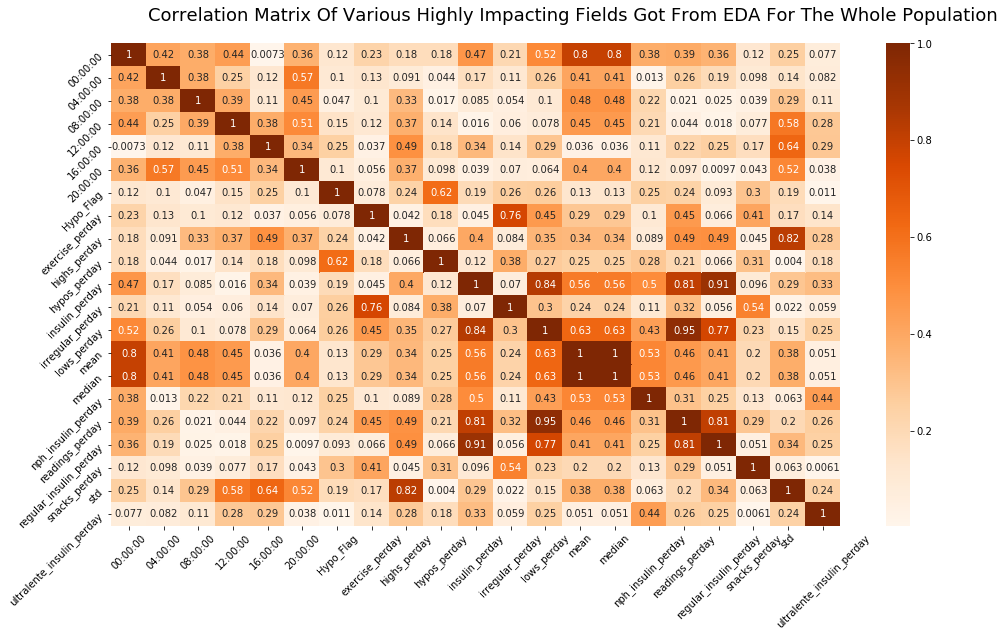

In [755]:

fig = plt.gcf()
fig.suptitle('Correlation Matrix Of Various Highly Impacting Fields Got From EDA For The Whole Population', 
             fontsize=18, horizontalalignment = 'center')
fig.set_size_inches(16, 10, forward=True)
corr = np.absolute(df_pivot.corr())
plt.yticks(rotation=45) 
plt.xticks(rotation=45)
sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='Oranges', cbar_kws={"orientation": "vertical"})

plt.yticks(rotation=45) 
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.1, 0.9, 0.95])
plt.show()

In [732]:
corr.sort_values(by='hypos_perday', ascending=False).hypos_perday

hypos_perday                 1.000000
Hypo_Flag                    0.615263
irregular_perday             0.381904
snacks_perday                0.305942
nph_insulin_perday           0.282615
lows_perday                  0.270517
median                       0.252419
mean                         0.252419
readings_perday              0.208021
00:00:00                     0.181078
ultralente_insulin_perday    0.179663
16:00:00                     0.178393
exercise_perday              0.176593
12:00:00                     0.142079
insulin_perday               0.118601
20:00:00                     0.097823
regular_insulin_perday       0.066408
highs_perday                 0.065586
04:00:00                     0.044280
08:00:00                     0.017163
std                          0.003976
Name: hypos_perday, dtype: float64

In [731]:
corr.sort_values(by='Hypo_Flag', ascending=False).Hypo_Flag

Hypo_Flag                    1.000000
hypos_perday                 0.615263
snacks_perday                0.299200
lows_perday                  0.262983
irregular_perday             0.259609
nph_insulin_perday           0.251723
16:00:00                     0.249561
highs_perday                 0.239779
readings_perday              0.237898
insulin_perday               0.192636
std                          0.187855
12:00:00                     0.146932
median                       0.132351
mean                         0.132351
00:00:00                     0.123379
20:00:00                     0.102657
04:00:00                     0.101468
regular_insulin_perday       0.093183
exercise_perday              0.078419
08:00:00                     0.047197
ultralente_insulin_perday    0.010624
Name: Hypo_Flag, dtype: float64

In [744]:
confusion_matrix(y_test, y_pred)

array([[5, 3],
       [5, 8]])

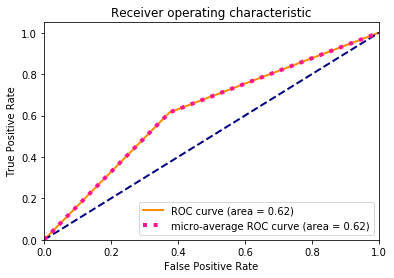

In [745]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(fpr_micro, tpr_micro,
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc_micro),
         color='deeppink', linestyle=':', linewidth=4)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()